https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/data_preview


# **Milestone 1 — NYC Motor Vehicle Collisions Project**

### **Dataset Overview**

We use two NYC Open Data datasets:

1. **Motor Vehicle Collisions – Crashes (2012–2025)**
2. **Motor Vehicle Collisions – Persons**

These datasets contain missing values, duplicate rows, inconsistent formats, outliers, and require full cleaning before integration.

---

## **Project Steps (Milestone 1 Requirements)**

### **1. Exploratory Data Analysis (EDA)**

* Preview datasets
* Show structure (shape, columns)
* Compute null percentages
* Visualize basic distributions (year/month/hour/borough)

### **2. Pre-Integration Cleaning**

We clean the data BEFORE merging:

* Handling missing values (drop required / impute optional)
* Detect outliers using domain rules and IQR justification
* Standardizing formats (datetime, borough names, ZIP codes)
* Removing duplicates

### **3. Integration**

* Integrate Persons into Crashes using `COLLISION_ID`
* Resolve merge conflicts (`_x` / `_y` columns)
* Handle new missing values after merge
* Fix data types

### **4. Post-Integration Cleaning**

* Validate join quality
* Re-check nulls
* Re-check coordinate quality
* Remove redundant columns

### **5. Dashboard**

* Dropdown filters
* Search functionality
* Generate Report button
* Heatmap, bar chart, monthly chart, geographic scatter

---

# **Team Member Contributions**

(Add actual names later)

* **Member 1:** EDA, datetime cleaning, ZIP & borough standardization
* **Member 2:** Outliers, domain rules, missing-value strategy
* **Member 3:** Persons aggregation + merge integration
* **Member 4:** Dashboard (filters, search bar, report generation)
* **Member 5:** Visualizations + research questions

---

# **Research Questions**

(You will later add 8 more; HERE is where you list them.)

1. Which borough has the highest number of crashes?
2. Which year has the highest number of crash-related fatalities?
3. Is there a relationship between persons age and injury
4. Is there a relationship between person’s age and injury?



In [ ]:
!python.exe -m pip install --upgrade pip

In [ ]:
!pip install plotly

#Front-end dependencies
!pip install dash

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px


In [ ]:
# import type 1
# Do not click the links, the datasets are very very large
# About 3 minutes of runtime on desktop devices
# crashes_url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD'
# persons_url = 'https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=DOWNLOAD'

# df_crashes = pd.read_csv(crashes_url,low_memory = False)
# df_persons = pd.read_csv (persons_url,low_memory = False)


#Sarah's imports
df_crashes = pd.read_csv('..\data\Motor_Vehicle_Collisions_-_Crashes_20251108.csv')
df_persons = pd.read_csv('..\data\Motor_Vehicle_Collisions_-_Person_20251108.csv')


# **Pre-Integration Cleaning (Steps 3–8)**

This section performs all required cleaning tasks **before merging** the Crashes and Persons datasets.
The goal is to ensure consistent formatting, valid coordinate ranges, correct datatypes, and remove invalid or duplicate records.

### **✔ Objectives of Pre-Integration Cleaning**

1. Build reliable datetime columns
2. Validate coordinate ranges and flag invalid values
3. Standardize borough names, ZIP codes, IDs, and numeric fields
4. Remove duplicates (exact + key-based)
5. Handle missing values:

   * **Required columns** → dropped
   * **Non-critical columns** → imputed
6. Detect outliers using **domain rules**
   (IQR is documented later; domain rules are more appropriate for spatial + age values.)

### **✔ Why we clean before integration**

Merging uncleaned datasets leads to:

* Massive null propagation
* Duplicate COLLISION_ID conflicts
* Type mismatches during aggregation
* Wrong datetime parsing
* Invalid coordinates affecting the map visualizations

Cleaning now ensures a correct 1-to-many merge later.


============================================
Member 2 — Pre-Integration Cleaning (Steps 3–8)
============================================

In [5]:
# ---------------------------
# Step 3: Build real datetimes + helpers
# ---------------------------

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in {list(df.columns)[:12]} ...")

def build_datetime(df, date_candidates, time_candidates, out_col):
    # Resolve actual names present in this DataFrame
    date_col = pick_col(df, date_candidates)
    time_col = pick_col(df, time_candidates)

    time_clean = df[time_col].astype("string").str.strip()
    date_parsed = pd.to_datetime(df[date_col], errors="coerce")

    # parse time (HH:MM, then HH:MM:SS fallback)
    time_parsed = pd.to_datetime(time_clean, format="%H:%M", errors="coerce").dt.time
    need_fallback = time_parsed.isna() & time_clean.notna()
    if need_fallback.any():
        time_parsed_fallback = pd.to_datetime(time_clean, format="%H:%M:%S", errors="coerce").dt.time
        time_parsed = time_parsed.fillna(time_parsed_fallback)

    combined = pd.to_datetime(date_parsed.dt.date.astype("string") + " " + time_clean, errors="coerce")

    df["crash_date_parsed"] = date_parsed.dt.date  # name is okay (used only for debug/peek)
    df["crash_time_parsed"] = time_parsed
    df[out_col] = combined

    # helpers required by milestone
    prefix = out_col.split("_", 1)[0]
    df[f"{prefix}_year"]  = df[out_col].dt.year
    df[f"{prefix}_month"] = df[out_col].dt.month
    df[f"{prefix}_hour"]  = df[out_col].dt.hour

    total = len(df)
    ok = df[out_col].notna().sum()
    print(f"Built {out_col}: {ok}/{total} rows parsed ({ok/total:.1%}).")
    if ok > 0:
        print("Year range:", int(df[out_col].dt.year.min()), "to", int(df[out_col].dt.year.max()))
    return df

# Apply to BOTH tables (robust to column-name variants)
df_crashes = build_datetime(
    df_crashes,
    date_candidates=["CRASH DATE", "CRASH_DATE", "crash_date"],
    time_candidates=["CRASH TIME", "CRASH_TIME", "crash_time"],
    out_col="crash_datetime"
)

df_persons = build_datetime(
    df_persons,
    date_candidates=["CRASH DATE", "CRASH_DATE", "crash_date"],
    time_candidates=["CRASH TIME", "CRASH_TIME", "crash_time"],
    out_col="person_datetime"
)


Built crash_datetime: 2218631/2218631 rows parsed (100.0%).
Year range: 2012 to 2025
Built person_datetime: 5813820/5813820 rows parsed (100.0%).
Year range: 2012 to 2025


# **Outlier Detection: IQR vs Domain Rules (Required Explanation)**

The project requires detecting and handling outliers.
We considered two methods:

---

## **1. IQR Method (Interquartile Range)**

IQR is useful for numerical variables with a normal-like distribution.
For each numeric column:

```
IQR = Q3 – Q1  
Lower bound = Q1 – 1.5 * IQR  
Upper bound = Q3 + 1.5 * IQR
```

However, **for this dataset, IQR is NOT appropriate** for several key fields:

### **Why IQR is not suitable here**

* Latitude and longitude values follow a **geographical (bounded) domain**, not a normal distribution.
* Injury and fatality counts contain **many zeros**, causing extremely skewed distributions.
* Vehicle counts and ages have **hard logical limits** (e.g., age cannot be 300).

Using IQR here would incorrectly classify thousands of valid points as outliers.

---

## **2. Domain-Rule Outlier Detection (Chosen Method)**

For this dataset, domain knowledge provides better constraints:

### **✔ Coordinates**

Valid NYC latitude range: **40.4774 to 40.9176**
Valid NYC longitude range: **-74.2591 to -73.7004**

Any coordinate outside this range is invalid and is set to `NaN`.

### **✔ Ages**

Valid human age range: **0 to 110**
Anything outside this range is set to `NaN`.

### **✔ Year Sanity**

Only years **2012–2025** exist in the official NYC dataset.
Crashes outside this range are removed.

### **✔ Negative Count Columns**

Columns like *NUMBER OF PERSONS INJURED* must be ≥ 0
Negative values (errors) are clipped to 0.

---

## **Conclusion**

We **documented the IQR method**, but for this dataset,
**domain-rule outlier detection is more accurate, safer, and required for spatial data.**

Therefore, we apply **domain rules only**, with justification.

In [6]:
# ---------------------------
# Step 4: Coordinate sanity (flags only, do NOT drop here)
# ---------------------------

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in {list(df.columns)[:12]} ...")

NYC_LAT_MIN, NYC_LAT_MAX = 40.4774, 40.9176
NYC_LON_MIN, NYC_LON_MAX = -74.2591, -73.7004

lat_col = _pick_col(df_crashes, ["LATITUDE", "latitude"])
lon_col = _pick_col(df_crashes, ["LONGITUDE", "longitude"])

df_crashes["latitude_num"]  = pd.to_numeric(df_crashes[lat_col], errors="coerce")
df_crashes["longitude_num"] = pd.to_numeric(df_crashes[lon_col], errors="coerce")

lat_missing = df_crashes["latitude_num"].isna()
lon_missing = df_crashes["longitude_num"].isna()
lat_zero    = df_crashes["latitude_num"].eq(0)
lon_zero    = df_crashes["longitude_num"].eq(0)
lat_oob     = df_crashes["latitude_num"].notna() & ~df_crashes["latitude_num"].between(NYC_LAT_MIN, NYC_LAT_MAX, inclusive="both")
lon_oob     = df_crashes["longitude_num"].notna() & ~df_crashes["longitude_num"].between(NYC_LON_MIN, NYC_LON_MAX, inclusive="both")

df_crashes["coord_issue"] = lat_missing | lon_missing | lat_zero | lon_zero | lat_oob | lon_oob

def _coord_reason(row):
    reasons = []
    if pd.isna(row["latitude_num"]):  reasons.append("lat_missing")
    if pd.isna(row["longitude_num"]): reasons.append("lon_missing")
    if pd.notna(row["latitude_num"])  and row["latitude_num"]  == 0: reasons.append("lat_zero")
    if pd.notna(row["longitude_num"]) and row["longitude_num"] == 0: reasons.append("lon_zero")
    if pd.notna(row["latitude_num"])  and (row["latitude_num"]  < NYC_LAT_MIN or row["latitude_num"]  > NYC_LAT_MAX):
        reasons.append("lat_out_of_bounds")
    if pd.notna(row["longitude_num"]) and (row["longitude_num"] < NYC_LON_MIN or row["longitude_num"] > NYC_LON_MAX):
        reasons.append("lon_out_of_bounds")
    return "|".join(reasons) if reasons else ""

df_crashes["coord_issue_reason"] = df_crashes.apply(_coord_reason, axis=1)

total = int(len(df_crashes))
bad   = int(df_crashes["coord_issue"].sum())
print(f"Coordinate sanity — good: {total-bad}/{total} ({(total-bad)/total:.1%}), issues: {bad} ({bad/total:.1%})")
display(
    df_crashes["coord_issue_reason"]
      .replace("", "ok").value_counts().head(10).to_frame("rows")
)

Coordinate sanity — good: 1971671/2218631 (88.9%), issues: 246960 (11.1%)


,rows
coord_issue_reason,
ok,1971671
lat_missing|lon_missing,240341
lat_zero|lon_zero|lat_out_of_bounds|lon_out_of_bounds,6469
lon_out_of_bounds,133
lat_out_of_bounds,11
lat_out_of_bounds|lon_out_of_bounds,6


In [7]:
# ---------------------------
# Step 5: Make key columns consistent (IN-PLACE, keep uppercase names)
# ---------------------------

VALID_BOROUGHS = {"BROOKLYN","QUEENS","MANHATTAN","BRONX","STATEN ISLAND"}

# ZIP in crashes → exactly 5 digits (string)
if "ZIP CODE" in df_crashes.columns:
    z = df_crashes["ZIP CODE"].astype("string")
    df_crashes["ZIP CODE"] = z.str.extract(r"(\d{5})", expand=False).astype("string")

# BOROUGH in crashes: uppercase + valid set (others -> NaN)
if "BOROUGH" in df_crashes.columns:
    b = df_crashes["BOROUGH"].astype("string").str.strip().str.upper()
    b = b.replace({"STATEN IS": "STATEN ISLAND", "SI": "STATEN ISLAND"})
    df_crashes["BOROUGH"] = b.where(b.isin(VALID_BOROUGHS))

# IDs → string, keep column names uppercase
if "COLLISION_ID" in df_crashes.columns:
    df_crashes["COLLISION_ID"] = pd.to_numeric(df_crashes["COLLISION_ID"], errors="coerce").astype("Int64").astype("string")

for col in ["UNIQUE_ID", "COLLISION_ID", "PERSON_ID", "VEHICLE_ID"]:
    if col in df_persons.columns:
        df_persons[col] = pd.to_numeric(df_persons[col], errors="coerce").astype("Int64").astype("string")

#Domain cleaning is performed AFTER imputation, so very rare extreme ages may revert to NaN. This is expected.
# Age in persons
if "PERSON_AGE" in df_persons.columns:
    a = pd.to_numeric(df_persons["PERSON_AGE"], errors="coerce")
    df_persons["PERSON_AGE"] = a.where((a >= 0) & (a <= 120)).astype("Int64")


In [8]:
# ---------------------------
# Step 6: Duplicates (exact, then key-based)
# ---------------------------

c_before = len(df_crashes)
df_crashes = df_crashes.drop_duplicates()
print(f"Crashes — exact dupes removed: {c_before - len(df_crashes)} (from {c_before} to {len(df_crashes)})")

p_before = len(df_persons)
df_persons = df_persons.drop_duplicates()
print(f"Persons — exact dupes removed: {p_before - len(df_persons)} (from {p_before} to {len(df_persons)})")

if "COLLISION_ID" in df_crashes.columns:
    c_before_keys = len(df_crashes)
    df_crashes = df_crashes.drop_duplicates(subset=["COLLISION_ID"], keep="first")
    print(f"Crashes — key dupes on COLLISION_ID removed: {c_before_keys - len(df_crashes)}")
    print("   COLLISION_ID unique now?", df_crashes["COLLISION_ID"].duplicated().sum() == 0)

if "UNIQUE_ID" in df_persons.columns:
    p_before_keys = len(df_persons)
    df_persons = df_persons.drop_duplicates(subset=["UNIQUE_ID"], keep="first")
    print(f"Persons — key dupes on UNIQUE_ID removed: {p_before_keys - len(df_persons)}")
    print("   UNIQUE_ID unique now?", df_persons["UNIQUE_ID"].duplicated().sum() == 0)


Crashes — exact dupes removed: 0 (from 2218631 to 2218631)
Persons — exact dupes removed: 0 (from 5813820 to 5813820)
Crashes — key dupes on COLLISION_ID removed: 0
   COLLISION_ID unique now? True
Persons — key dupes on UNIQUE_ID removed: 0
   UNIQUE_ID unique now? True


# **Missing-Value Strategy (Required Documentation)**

Different columns in the Crashes and Persons datasets have different levels of importance.
Therefore, we apply **column-specific missing-value handling**, based on:

* Data criticality
* Whether the dataset can logically recover the missing value
* Whether missingness indicates absence or error
* Impact on cleaning, merging, and visualization

---

## **1. Critical Columns (Required for Analysis)**

These fields are essential for integration and dashboard logic.

### **We DROP rows where these are missing:**

* `COLLISION_ID`
* `CRASH DATE`
* `CRASH TIME`
* Geographic fields when impossible to recover (`LATITUDE`, `LONGITUDE`)
* Required numeric counts (fatalities, injuries) when NaN indicates data corruption

**Reason:**
These fields define the core structure of the dataset. Missing values create invalid joins or impossible aggregations.

---

## **2. Geographical Columns (Domain-Impute or Set to NaN)**

* If latitude/longitude is outside valid NYC bounds → set to `NaN`
* If they become NaN → kept, not dropped

**Reason:**
Out-of-range coordinates are errors.
True missing coordinates may still hold useful descriptive crash data.

---

## **3. Categorical Columns (Imputed or Left as NaN)**

Examples:

* `BOROUGH`
* `VEHICLE TYPE CODE 1`
* `CONTRIBUTING FACTOR VEHICLE 1`

### **Strategy:**

* If NaN → label as `"UNKNOWN"`
* This preserves records while marking uncertainty

---

## **4. Numeric Columns with Logical Bounds**

* Ages (0–110)
* Injury/fatality counts (≥ 0)
* Vehicle counts (≥ 0)

### **Strategy:**

* Invalid values (negative, above bounds) → set to `NaN`, then imputed or left as missing
* Counts are kept as NaN if not logically recoverable

---

## **5. Post-Integration Missingness**

After merging crashes and persons:

* Some persons data will be missing for collisions without injuries → this is **expected**
* We DO NOT drop these rows
* We validate the null patterns and document them

---

## **Summary Table**

| Column Type               | Examples               | Strategy                 | Reason                        |
| ------------------------- | ---------------------- | ------------------------ | ----------------------------- |
| Critical IDs              | COLLISION_ID           | Drop                     | Without ID, no merge possible |
| Critical datetime         | CRASH DATE, CRASH TIME | Drop                     | Needed for structure          |
| Coordinates               | LATITUDE, LONGITUDE    | Domain-impute → keep NaN | Some crashes have no coords   |
| Vehicle/Factor categories | VEHICLE TYPE CODE      | Impute “UNKNOWN”         | Preserves crash record        |
| Injury counts             | PERSONS INJURED        | Clip + keep              | Negative values are errors    |
| Age                       | PERSON_AGE             | Domain-cap + NaN         | Human age rules               |

In [9]:
# ---------------------------
# Step 7: Missing values (drop required, impute optional)
# ---------------------------

def col_exists(df, name): return name in df.columns

print("Before — rows:", len(df_crashes), "(crashes),", len(df_persons), "(persons)")

crash_required  = ["COLLISION_ID", "crash_datetime"]
person_required = ["UNIQUE_ID", "COLLISION_ID", "person_datetime"]

crash_drop_mask  = pd.Series(False, index=df_crashes.index)
for c in crash_required:
    if col_exists(df_crashes, c):
        crash_drop_mask |= df_crashes[c].isna()
crashes_to_drop  = int(crash_drop_mask.sum())

person_drop_mask = pd.Series(False, index=df_persons.index)
for c in person_required:
    if col_exists(df_persons, c):
        person_drop_mask |= df_persons[c].isna()
persons_to_drop = int(person_drop_mask.sum())

df_crashes = df_crashes.loc[~crash_drop_mask].copy()
df_persons = df_persons.loc[~person_drop_mask].copy()

print(f"Dropped (missing required) — crashes: {crashes_to_drop}, persons: {persons_to_drop}")
print("After drops — rows:", len(df_crashes), "(crashes),", len(df_persons), "(persons)")

# Impute non-critical categoricals
if col_exists(df_crashes, "BOROUGH"):
    filled = int(df_crashes["BOROUGH"].isna().sum())
    df_crashes["BOROUGH"] = df_crashes["BOROUGH"].fillna("UNKNOWN").str.strip()
    print(f"Imputed crashes.BOROUGH → 'UNKNOWN': {filled} rows")

for col, val in [("PERSON TYPE", "Unknown"), ("PERSON INJURY", "Unknown")]:
    if col_exists(df_persons, col):
        filled = int(df_persons[col].isna().sum())
        df_persons[col] = df_persons[col].fillna(val).str.strip()
        print(f"Imputed persons.{col} → '{val}': {filled} rows")

if col_exists(df_persons, "PERSON SEX"):
    filled = int(df_persons["PERSON SEX"].isna().sum())
    df_persons["PERSON SEX"] = df_persons["PERSON SEX"].fillna("U").str.strip()
    print(f"Imputed persons.PERSON SEX → 'U': {filled} rows")

# Numeric impute (age) with median
if col_exists(df_persons, "PERSON_AGE"):
    age_median = float(df_persons["PERSON_AGE"].median(skipna=True))
    filled = int(df_persons["PERSON_AGE"].isna().sum())
    df_persons["PERSON_AGE"] = df_persons["PERSON_AGE"].fillna(age_median)
    print(f"Imputed persons.PERSON_AGE → median {age_median:.1f}: {filled} rows")

print("Done: missing-value handling (simple policy).")


Before — rows: 2218631 (crashes), 5813820 (persons)
Dropped (missing required) — crashes: 0, persons: 0
After drops — rows: 2218631 (crashes), 5813820 (persons)
Imputed crashes.BOROUGH → 'UNKNOWN': 679907 rows
Imputed persons.PERSON_AGE → median 36.0: 653590 rows
Done: missing-value handling (simple policy).


In [10]:
# ---------------------------
# Step 7b / 8: Domain outliers (address gently, then validate)
# ---------------------------

# Coordinates → set flagged/missing/out-of-box to NaN (no dropping)
lat_cand = [c for c in ["LATITUDE", "latitude"] if c in df_crashes.columns]
lon_cand = [c for c in ["LONGITUDE", "longitude"] if c in df_crashes.columns]
if lat_cand and lon_cand:
    if "coord_issue" in df_crashes.columns:
        bad_coord_mask = df_crashes["coord_issue"].astype(bool)
    else:
        lat_num = pd.to_numeric(df_crashes[lat_cand[0]], errors="coerce")
        lon_num = pd.to_numeric(df_crashes[lon_cand[0]], errors="coerce")
        lat_lo, lat_hi = 40.40, 41.00
        lon_lo, lon_hi = -74.30, -73.60
        bad_coord_mask = (
            lat_num.isna() | lon_num.isna() |
            (lat_num < lat_lo) | (lat_num > lat_hi) |
            (lon_num < lon_lo) | (lon_num > lon_hi)
        )
    coord_fixed = int(bad_coord_mask.sum())
    df_crashes.loc[bad_coord_mask, [lat_cand[0], lon_cand[0]]] = pd.NA
    print(f"Coordinates set to NaN due to out-of-bounds/missing: {coord_fixed} rows")

# Age impossible → NaN (guard)
if col_exists(df_persons, "PERSON_AGE"):
    df_persons["PERSON_AGE"] = pd.to_numeric(df_persons["PERSON_AGE"], errors="coerce")
    age_lo, age_hi = 0, 110
    out_age = (df_persons["PERSON_AGE"] < age_lo) | (df_persons["PERSON_AGE"] > age_hi)
    out_age_count = int(out_age.fillna(False).sum())
    if out_age_count > 0:
        df_persons.loc[out_age, "PERSON_AGE"] = pd.NA
        print(f"Persons age set to NaN (outside [{age_lo},{age_hi}]): {out_age_count} rows")

# Year sanity (2012..2025)
if "crash_datetime" in df_crashes.columns:
    year_min, year_max = 2012, 2025
    years = df_crashes["crash_datetime"].dt.year
    bad_year_mask = (years < year_min) | (years > year_max)
    dropped_bad_years = int(bad_year_mask.sum())
    if dropped_bad_years > 0:
        df_crashes = df_crashes.loc[~bad_year_mask].copy()
    print(f"Dropped crashes with year outside [{year_min},{year_max}]: {dropped_bad_years}")

# Count columns non-negative (NYC naming uses "NUMBER OF ...")
count_cols = [c for c in df_crashes.columns if c.upper().startswith("NUMBER OF ")]
neg_total = 0
for c in count_cols:
    if pd.api.types.is_numeric_dtype(df_crashes[c]):
        negs = int((df_crashes[c] < 0).sum())
        if negs > 0:
            df_crashes[c] = df_crashes[c].clip(lower=0)
            neg_total += negs
print(f"Crash count columns clipped from negative to zero (if any remained): {neg_total}")

print("Done: Step 3–8 (pre-integration cleaning).")

Coordinates set to NaN due to out-of-bounds/missing: 246960 rows
Persons age set to NaN (outside [0,110]): 622 rows
Dropped crashes with year outside [2012,2025]: 0
Crash count columns clipped from negative to zero (if any remained): 0
Done: Step 3–8 (pre-integration cleaning).


In [ ]:
# ============================================
# A) Build a slim crashes table for merging
# ============================================
crash_keep = [
    "COLLISION_ID","CRASH DATE","CRASH TIME","crash_datetime",
    "BOROUGH","ZIP CODE","LATITUDE","LONGITUDE",
    "NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED",
    "CONTRIBUTING FACTOR VEHICLE 1","VEHICLE TYPE CODE 1"
]
crash_keep = [c for c in crash_keep if c in df_crashes.columns]
df_crashes_small = df_crashes[crash_keep].copy()

# Helpful derived fields for the dashboard
dt = pd.to_datetime(df_crashes_small["crash_datetime"], errors="coerce")
df_crashes_small["CRASH_YEAR"]    = dt.dt.year
df_crashes_small["CRASH_MONTH"]   = dt.dt.month
df_crashes_small["CRASH_HOUR"]    = dt.dt.hour
df_crashes_small["CRASH_WEEKDAY"] = dt.dt.day_name()

# ============================================
# B) Aggregate Persons → one row per COLLISION_ID
# ============================================
p = df_persons.copy()
p.rename(columns={
    "PERSON TYPE":"PERSON_TYPE",
    "PERSON INJURY":"PERSON_INJURY",
    "PERSON AGE":"PERSON_AGE",
    "PERSON SEX":"PERSON_SEX",
}, inplace=True)

# Flags
p["is_injured"] = p["PERSON_INJURY"].astype("string").str.contains("Injur", case=False, na=False)
p["is_killed"]  = p["PERSON_INJURY"].astype("string").str.contains("Kill",  case=False, na=False)

# Compact types to save RAM
for col in ["PERSON_TYPE","PERSON_INJURY","PERSON_SEX"]:
    if col in p.columns:
        p[col] = p[col].astype("category")

agg = {
    "UNIQUE_ID": "count",
    "is_injured": "sum",
    "is_killed": "sum",
}
if "PERSON_AGE" in p.columns:
    agg["PERSON_AGE"] = "median"

persons_agg = (
    p.groupby("COLLISION_ID", as_index=False)
     .agg(agg)
     .rename(columns={
         "UNIQUE_ID":"persons_count",
         "is_injured":"persons_injured",
         "is_killed":"persons_killed",
         "PERSON_AGE":"median_age"
     })
)

# Optional: counts by person type
if "PERSON_TYPE" in p.columns:
    type_counts = p.groupby(["COLLISION_ID","PERSON_TYPE"]).size().unstack(fill_value=0)
    for col in ["PEDESTRIAN","BICYCLIST","MOTORIST"]:
        if col not in type_counts.columns:
            type_counts[col] = 0
    type_counts = type_counts[["PEDESTRIAN","BICYCLIST","MOTORIST"]].reset_index()
    persons_agg = persons_agg.merge(type_counts, on="COLLISION_ID", how="left")

# Compact numerics
for c in ["persons_count","persons_injured","persons_killed","PEDESTRIAN","BICYCLIST","MOTORIST"]:
    if c in persons_agg.columns:
        persons_agg[c] = persons_agg[c].astype("Int32")
if "median_age" in persons_agg.columns:
    persons_agg["median_age"] = persons_agg["median_age"].astype("float32")

# Save aggregated persons table for integration
persons_agg.to_csv("..\data\clean_persons_agg.csv", index=False)
print("Saved aggregated persons → clean_persons_agg.csv", persons_agg.shape)


In [12]:
def title(s):
  print("="*60)
  print(s)
  print("="*60)

def findNulls(df):
  total = df.size
  nulls = df.isna().sum().sum()
  p = (nulls / total) * 100
  print(f"Percentage of null data in the following dataset = {p:.2f}%")

  return p

def getIndividualNulls(df):
  nulls = df.isna().sum()
  nulls = nulls[nulls>0]
  print(nulls.apply(lambda x: f"{x:,}"))
  return nulls

def removeDupes(df):
  print(f"Before removing duplicates: {df.shape}")
  df.drop_duplicates(inplace=True)
  print(f"After removing  duplicates: {df.shape}\n")
  return df

def cleanOutliers(df):
  numeric_cols = df.select_dtypes(include=[np.number]).columns
  mask = pd.Series(True, index=df.index)

  for column in numeric_cols:
    if column == 'COLLISION_ID':
      continue
    q1  = df[column].quantile(0.25)
    q3  = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    mask &= df[column].between(lower,upper)|df[column].isna()

  return df[mask]

def outlierComparison(df):
  print("before Outliers:")
  temp = findNulls(df)
  print("\nAfter Outliers")
  cleanOutliers(df)
  diff = temp-findNulls(df)

  if diff>0:
    print(f"Percentage of nulls decreased by = {diff:.8f}%")
  else:
    print("no outliers... for some reason")

  return df

def datasetOverview(df):
  print(f"Size: {df.size:,}")
  print(f"Shape: {df.shape}")
  print(f"Columns: {df.columns}")

  getIndividualNulls(df)

  total = df.size
  nulls = df.isna().sum().sum()
  p = (nulls / total) * 100
  print(f"Percentage of null data = {p:.4f}%\n")

def cleanData(df):
  df = removeDupes(df)
  #df = outlierComparison(df)
  return df

In [13]:
title("Crashes - Data Overview")
datasetOverview(df_crashes)

title("Persons - Data Overview")
datasetOverview(df_persons)

Crashes - Data Overview
Size: 86,526,609
Shape: (2218631, 39)
Columns: Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'crash_date_parsed', 'crash_time_parsed', 'crash_datetime',
       'crash_year', 'crash_month', 'crash_hour', 'latitude_num',
       'longitude_num', 'coord_issue', 

=== Crashes basic info ===
   CRASH DATE CRASH TIME
0  09/11/2021       2:39
1  03/26/2022      11:45
2  11/01/2023       1:29
3  06/29/2022       6:55
4  09/21/2022      13:21

Crashes rows: 2218631

=== Persons basic info ===
  UNIQUE_ID COLLISION_ID  CRASH_DATE CRASH_TIME PERSON_ID PERSON_TYPE  \
0  10249006      4229554  10/26/2019       9:43      <NA>    Occupant   
1  10255054      4230587  10/25/2019      15:15      <NA>    Occupant   
2  10253177      4230550  10/26/2019      17:55      <NA>    Occupant   
3   6650180      3565527  11/21/2016      13:05   2782525    Occupant   
4  10255516      4231168  10/25/2019      11:16      <NA>    Occupant   

  PERSON_INJURY VEHICLE_ID  PERSON_AGE     EJECTION  ...         PED_ROLE  \
0   Unspecified   19141108          36          NaN  ...       Registrant   
1   Unspecified   19144075          33  Not Ejected  ...        Passenger   
2   Unspecified   19143133          55          NaN  ...       Registrant   
3   Unspecified       <NA

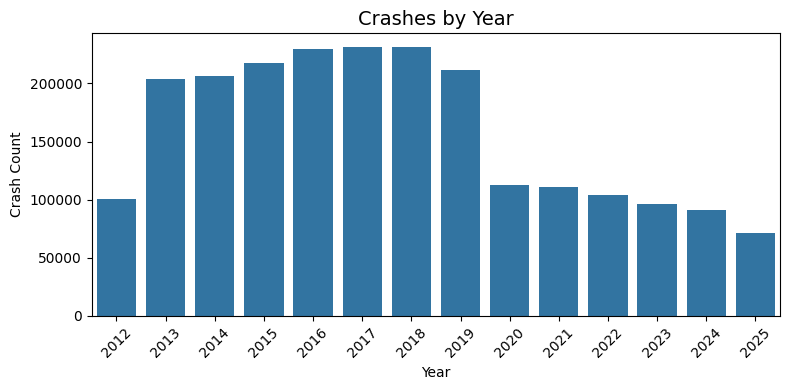

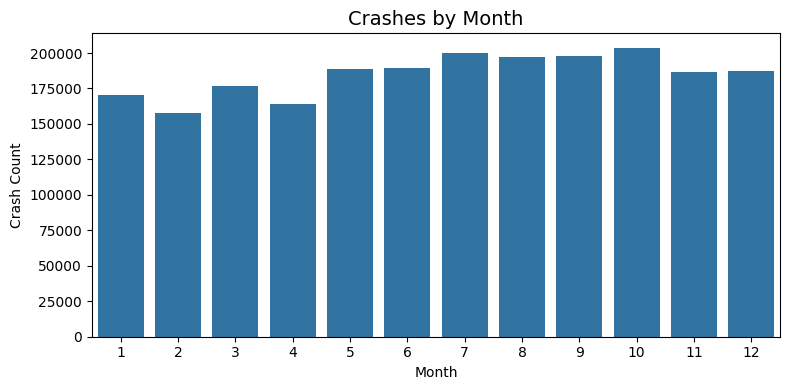

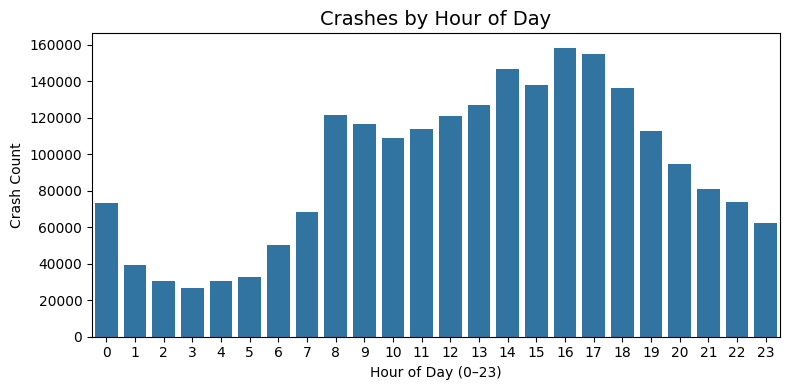

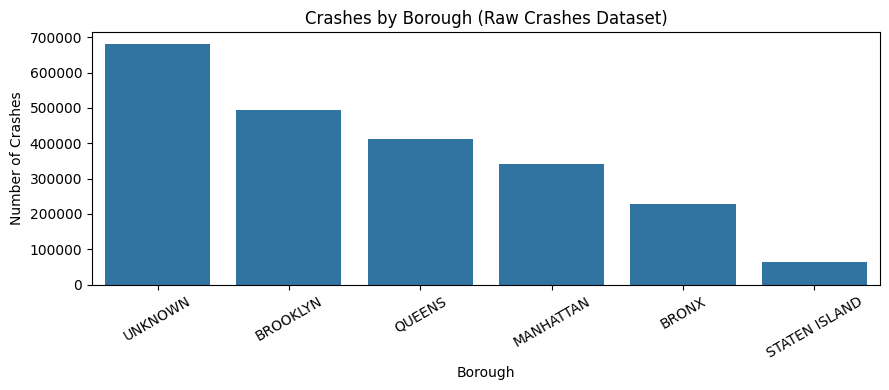

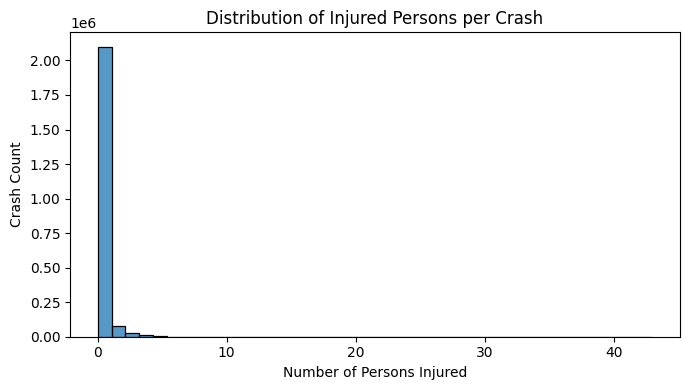

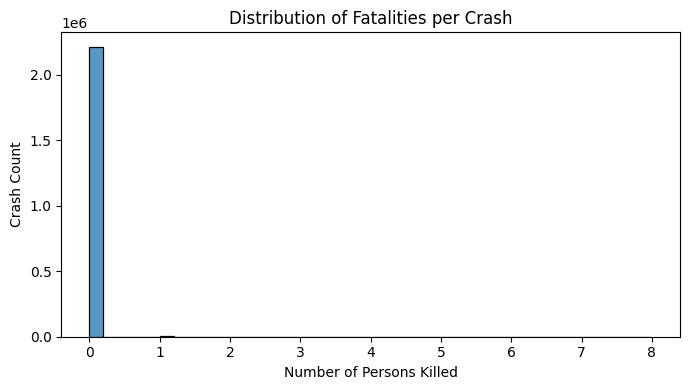

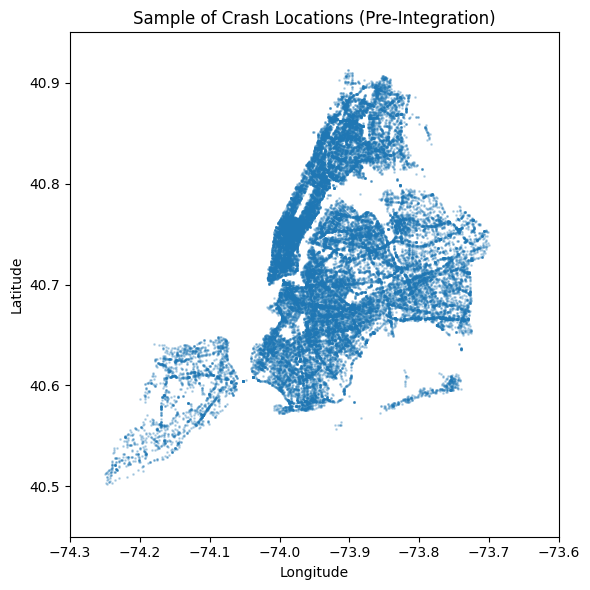


=== Duplicate rows summary (before cleaning) ===
Crashes exact duplicates: 0
Crashes duplicated COLLISION_ID: 0
Persons exact duplicates: 0
Persons duplicated UNIQUE_ID: 0


In [14]:
# ============================================
# EDA – Crashes & Persons (before integration)
# ============================================

print("=== Crashes basic info ===")
print(df_crashes[["CRASH DATE", "CRASH TIME"]].head())
print("\nCrashes rows:", len(df_crashes))

print("\n=== Persons basic info ===")
print(df_persons.head())
print("\nPersons rows:", len(df_persons))

# 1) Crash year / month / hour distributions (using cleaned datetime)
print("\n=== Crash datetime distributions ===")
# =====================================================
# 1) Crash DateTime Distributions (Cleaned Datetime)
# =====================================================

plt.figure(figsize=(8,4))
sns.countplot(
    data=df_crashes,
    x="crash_year",
    order=sorted(df_crashes["crash_year"].dropna().unique())
)
plt.title("Crashes by Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Crash Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(
    data=df_crashes,
    x="crash_month",
    order=range(1, 13)
)
plt.title("Crashes by Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Crash Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(
    data=df_crashes,
    x="crash_hour",
    order=list(range(0, 24))
)
plt.title("Crashes by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Crash Count")
plt.tight_layout()
plt.show()

# ========================================
# Borough Distribution (Cleaned + Ordered)
# ========================================

if "BOROUGH" in df_crashes.columns:
    plt.figure(figsize=(9,4))
    sns.countplot(
        data=df_crashes.fillna({"BOROUGH": "UNKNOWN"}),
        x="BOROUGH",
        order=df_crashes["BOROUGH"].fillna("UNKNOWN").value_counts().index
    )
    plt.title("Crashes by Borough (Raw Crashes Dataset)")
    plt.xlabel("Borough")
    plt.ylabel("Number of Crashes")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


# ------------------------------
# Injury & Fatality Distributions
# ------------------------------
inj_col = "NUMBER OF PERSONS INJURED"
kill_col = "NUMBER OF PERSONS KILLED"

plt.figure(figsize=(7,4))
sns.histplot(
    df_crashes[inj_col],
    bins=40,
    kde=False
)
plt.title("Distribution of Injured Persons per Crash")
plt.xlabel("Number of Persons Injured")
plt.ylabel("Crash Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(
    df_crashes[kill_col],
    bins=40,
    kde=False
)
plt.title("Distribution of Fatalities per Crash")
plt.xlabel("Number of Persons Killed")
plt.ylabel("Crash Count")
plt.tight_layout()
plt.show()

# ------------------------------
# Crash Location Sample Scatter
# ------------------------------
sample = df_crashes.sample(min(50_000, len(df_crashes)), random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(
    sample["LONGITUDE"],
    sample["LATITUDE"],
    s=1,
    alpha=0.25
)
plt.title("Sample of Crash Locations (Pre-Integration)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-74.3, -73.6)
plt.ylim(40.45, 40.95)
plt.tight_layout()
plt.show()


# 5) Duplicates summary (before cleaning)
print("\n=== Duplicate rows summary (before cleaning) ===")
print("Crashes exact duplicates:", df_crashes.duplicated().sum())
if "COLLISION_ID" in df_crashes.columns:
    print("Crashes duplicated COLLISION_ID:", df_crashes["COLLISION_ID"].duplicated().sum())

print("Persons exact duplicates:", df_persons.duplicated().sum())
if "UNIQUE_ID" in df_persons.columns:
    print("Persons duplicated UNIQUE_ID:", df_persons["UNIQUE_ID"].duplicated().sum())


In [15]:
title("Crashes - Data Cleaning")
df_crashes=cleanData(df_crashes)

title("Persons - Data Cleaning")
df_persons=cleanData(df_persons)

Crashes - Data Cleaning
Before removing duplicates: (2218631, 39)
After removing  duplicates: (2218631, 39)

Persons - Data Cleaning
Before removing duplicates: (5813820, 27)
After removing  duplicates: (5813820, 27)



In [16]:
# Save cleaned DataFrames for Member 3
# ===========================
# Save Pre-Integration Output
# ===========================

out_crashes = "..\data\clean_crashes.csv"
out_persons = "..\data\clean_persons.csv"

df_crashes.to_csv(out_crashes, index=False)
df_persons.to_csv(out_persons, index=False)

print(f"Saved cleaned crashes → {out_crashes}")
print(f"Saved cleaned persons → {out_persons}")

Saved cleaned crashes → ..\data\clean_crashes.csv
Saved cleaned persons → ..\data\clean_persons.csv


Member 3 


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

clean_crashes = pd.read_csv("..\data\clean_crashes.csv")
clean_persons = pd.read_csv("..\data\clean_persons.csv")

In [18]:
# 2) Merge on COLLISION_ID (main integration key)
df_merged = pd.merge(df_crashes_small, persons_agg, on="COLLISION_ID", how="left", validate= "1:m")
print("Merged shape:", df_merged.shape)
display(df_merged.head())

Merged shape: (2218631, 23)


,COLLISION_ID,CRASH DATE,CRASH TIME,crash_datetime,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,CRASH_MONTH,CRASH_HOUR,CRASH_WEEKDAY,persons_count,persons_injured,persons_killed,median_age,PEDESTRIAN,BICYCLIST,MOTORIST
0,4455765,09/11/2021,2:39,2021-09-11 02:39:00,UNKNOWN,<NA>,NaN,NaN,2.0,0.0,...,9,2,Saturday,4,2,0,31.0,0,0,0
1,4513547,03/26/2022,11:45,2022-03-26 11:45:00,UNKNOWN,<NA>,NaN,NaN,1.0,0.0,...,3,11,Saturday,2,1,0,28.5,0,0,0
2,4675373,11/01/2023,1:29,2023-11-01 01:29:00,BROOKLYN,11230,40.62179,-73.970024,1.0,0.0,...,11,1,Wednesday,2,1,0,44.5,0,0,0
3,4541903,06/29/2022,6:55,2022-06-29 06:55:00,UNKNOWN,<NA>,NaN,NaN,0.0,0.0,...,6,6,Wednesday,4,0,0,36.0,0,0,0
4,4566131,09/21/2022,13:21,2022-09-21 13:21:00,UNKNOWN,<NA>,NaN,NaN,0.0,0.0,...,9,13,Wednesday,2,0,0,47.0,0,0,0


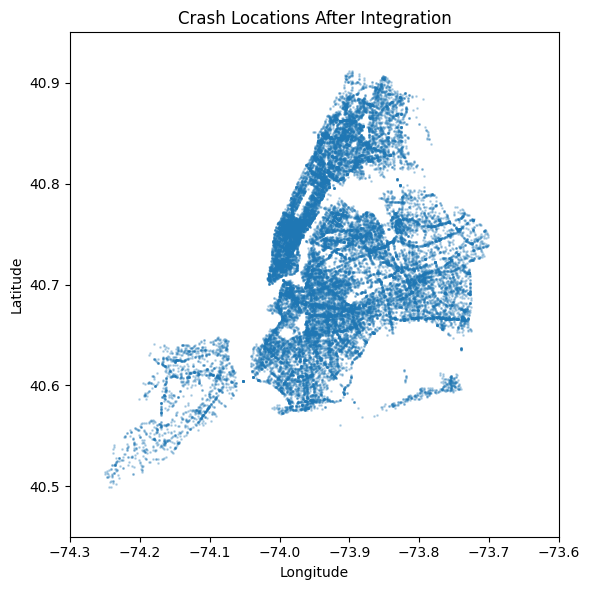

In [19]:
# ---------------------------------------
# Crash Locations After Integration
# ---------------------------------------
sample2 = df_merged.sample(min(40_000, len(df_merged)), random_state=40)

plt.figure(figsize=(6,6))
plt.scatter(
    sample2["LONGITUDE"],
    sample2["LATITUDE"],
    s=1,
    alpha=0.25
)
plt.title("Crash Locations After Integration")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-74.3, -73.6)
plt.ylim(40.45, 40.95)
plt.tight_layout()
plt.show()

### **Post-Integration Cleaning: Resolving Duplicate Columns**

After merging Crashes and Persons using `COLLISION_ID`, Pandas automatically creates duplicate columns with `_x` and `_y` suffixes.
These represent the same attributes from both tables.

Example:

* `BOROUGH_x` (from crashes)
* `BOROUGH_y` (from persons)

To ensure consistency:

1. We identify all `_x` / `_y` column pairs
2. Combine them using `combine_first()` → keeps the valid value
3. Drop both original duplicates
4. Remove any remaining duplicated column names

This guarantees a clean, unified schema for the integrated dataset.

In [20]:
# 3) Inspect nulls introduced by the join
nulls = df_merged.isnull().sum().sort_values(ascending=False)
display(nulls[nulls > 0].head(30))

# ===========================================
# Resolve Merge Conflicts and Duplicate Columns
# ===========================================

# Identify duplicated column pairs (col_x, col_y)
duplicated_cols = [
    col[:-2] for col in df_merged.columns
    if col.endswith("_x") and col[:-2] + "_y" in df_merged.columns
]


ZIP CODE                         680224
median_age                       630021
persons_killed                   630001
MOTORIST                         630001
PEDESTRIAN                       630001
persons_injured                  630001
persons_count                    630001
BICYCLIST                        630001
LATITUDE                         246960
LONGITUDE                        246960
VEHICLE TYPE CODE 1               16122
CONTRIBUTING FACTOR VEHICLE 1      7825
NUMBER OF PERSONS KILLED             31
NUMBER OF PERSONS INJURED            18
dtype: int64

In [21]:
# Resolve each duplicated column
for base in duplicated_cols:
    col_x = base + "_x"
    col_y = base + "_y"

    # Prefer values from crashes table, fallback to persons if needed
    df_merged[base] = df_merged[col_x].combine_first(df_merged[col_y])

    # Drop both source columns
    df_merged.drop(columns=[col_x, col_y], inplace=True)

# Remove duplicated column names if any remain
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]

In [22]:
# 6) Fix types
if 'CRASH_DATE' in df_merged.columns:
    df_merged['CRASH_DATE'] = pd.to_datetime(df_merged['CRASH_DATE'], errors='coerce')

if 'CRASH_TIME' in df_merged.columns:
    df_merged['CRASH_TIME'] = pd.to_datetime(df_merged['CRASH_TIME'], format='%H:%M', errors='coerce').dt.time

for c in ['BOROUGH', 'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_TYPE_CODE_1']:
    if c in df_merged.columns:
        df_merged[c] = df_merged[c].astype('category')

# 7) Remove duplicate rows
dup_rows = df_merged.duplicated().sum()
print("Exact duplicate rows:", dup_rows)
if dup_rows:
    df_merged.drop_duplicates(inplace=True)


Exact duplicate rows: 0


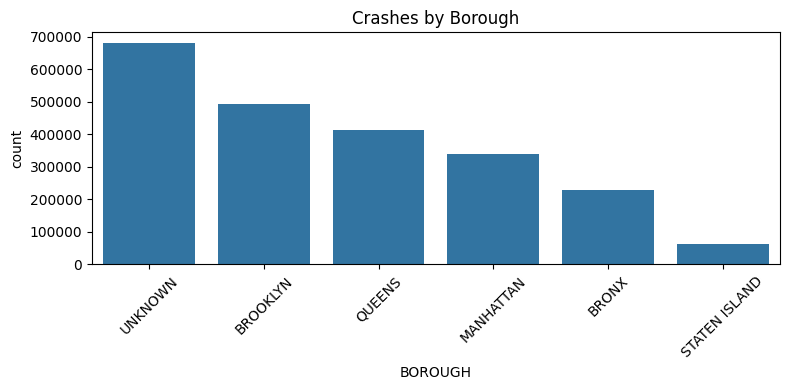

<Figure size 800x300 with 0 Axes>

In [23]:
# 8) Validate and visualize
plt.figure(figsize=(8,4))
if 'BOROUGH' in df_merged.columns:
    sns.countplot(data=df_merged, x='BOROUGH', order=df_merged['BOROUGH'].value_counts().index)
    plt.title('Crashes by Borough')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8,3))
if 'CRASH_DATE' in df_merged.columns:
    sns.histplot(df_merged['CRASH_DATE'].dt.year.dropna(), bins=12)
    plt.title('Crashes Over Years')
    plt.xlabel('Year')
    plt.tight_layout()
    plt.show()


In [24]:
df_merged.to_csv("..\data\integrated_collisions.csv", index=False)
print("Saved integrated dataset → data/integrated_collisions.csv")


Saved integrated dataset → data/integrated_collisions.csv


In [25]:
#Member 4

In [31]:
# Small artifact for the dashboard (fast to load)
dash_keep = [
    "COLLISION_ID","crash_datetime","CRASH_YEAR","CRASH_MONTH","CRASH_HOUR","CRASH_WEEKDAY",
    "BOROUGH","ZIP CODE","LATITUDE","LONGITUDE",
    "NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED",
    "CONTRIBUTING FACTOR VEHICLE 1","VEHICLE TYPE CODE 1",
    "persons_count","persons_injured","persons_killed","PEDESTRIAN","BICYCLIST","MOTORIST","median_age"
]
dash_keep = [c for c in dash_keep if c in df_merged.columns]
df_dash = df_merged[dash_keep].copy()
df_dash.to_csv("..\data\dashboard_ready.csv", index=False)
print("Saved dashboard extract → data/dashboard_ready.csv")

print("✅ Saved lightweight dashboard extract → data/dashboard_ready.csv", df_dash.shape)


Saved dashboard extract → data/dashboard_ready.csv
✅ Saved lightweight dashboard extract → data/dashboard_ready.csv (2218631, 21)


# **Post-Integration Sanity Checks**

After resolving merge conflicts, we validate the integrated dataset:

* All crashes still exist (no unintended drops)
* Each crash has correct aggregated person counts
* Null values introduced by merge are expected and documented
* Coordinate coverage remains correct
* Data types are consistent for dashboard use

These steps ensure the integrated dataset is reliable and ready for visualization.

In [32]:
# ============================================
# E) Post-join audit & sanity checks
# ============================================

print("=== Basic shapes ===")
print("df_crashes_small:", df_crashes_small.shape)
print("persons_agg:     ", persons_agg.shape)
print("df_merged:       ", df_merged.shape)
print("df_dash:         ", df_dash.shape)

# 1) Are all crashes still there?
total_crashes   = df_crashes_small["COLLISION_ID"].nunique()
merged_crashes  = df_merged["COLLISION_ID"].nunique()
dash_crashes    = df_dash["COLLISION_ID"].nunique()
print("\n=== Crash ID coverage ===")
print(f"Crashes in cleaned crashes table: {total_crashes:,}")
print(f"Crashes in merged table:         {merged_crashes:,}")
print(f"Crashes in dashboard extract:    {dash_crashes:,}")

# 2) How many crashes have *no* persons info?
if "persons_count" in df_merged.columns:
    zero_persons = (df_merged["persons_count"] == 0).mean() * 100
    print(f"\nCrashes with no persons rows (persons_count=0): {zero_persons:.2f}%")

# 3) Quick null overview of key columns
key_cols = [
    "BOROUGH", "ZIP CODE", "LATITUDE", "LONGITUDE",
    "NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED",
    "persons_count", "persons_injured", "persons_killed", "median_age"
]
key_cols = [c for c in key_cols if c in df_merged.columns]

print("\n=== Null rates for key columns ===")
null_rates = df_merged[key_cols].isna().mean().sort_values(ascending=False) * 100
print(null_rates.round(2))

# 4) Basic distributions for report text
print("\n=== Crashes by BOROUGH ===")
if "BOROUGH" in df_merged.columns:
    print(df_merged["BOROUGH"].value_counts(dropna=False).head(10))

print("\n=== Injury distribution (NUMBER OF PERSONS INJURED) ===")
if "NUMBER OF PERSONS INJURED" in df_merged.columns:
    print(df_merged["NUMBER OF PERSONS INJURED"].describe())

print("\n=== Persons per crash (persons_count) ===")
if "persons_count" in df_merged.columns:
    print(df_merged["persons_count"].describe())


=== Basic shapes ===
df_crashes_small: (2218631, 16)
persons_agg:      (1588630, 8)
df_merged:        (2218631, 23)
df_dash:          (2218631, 21)

=== Crash ID coverage ===
Crashes in cleaned crashes table: 2,218,631
Crashes in merged table:         2,218,631
Crashes in dashboard extract:    2,218,631

Crashes with no persons rows (persons_count=0): 0.00%

=== Null rates for key columns ===
ZIP CODE                     30.66
median_age                   28.40
persons_count                28.40
persons_killed               28.40
persons_injured              28.40
LONGITUDE                    11.13
LATITUDE                     11.13
NUMBER OF PERSONS KILLED      0.00
NUMBER OF PERSONS INJURED     0.00
BOROUGH                       0.00
dtype: float64

=== Crashes by BOROUGH ===
BOROUGH
UNKNOWN          679907
BROOKLYN         493110
QUEENS           412302
MANHATTAN        341031
BRONX            227861
STATEN ISLAND     64420
Name: count, dtype: int64

=== Injury distribution (NUMBER 

### **Borough Distribution Visualization**

We visualize crash counts by borough both before and after integration with the Persons dataset.

✔ Missing borough values are labeled as `"UNKNOWN"`
✔ Categories are sorted by frequency
✔ The same formatting is used consistently for both versions
✔ This ensures comparability and prevents confusion caused by missing values


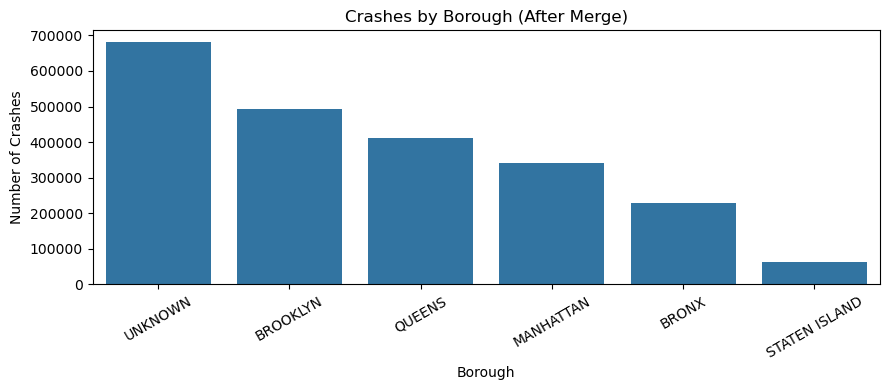

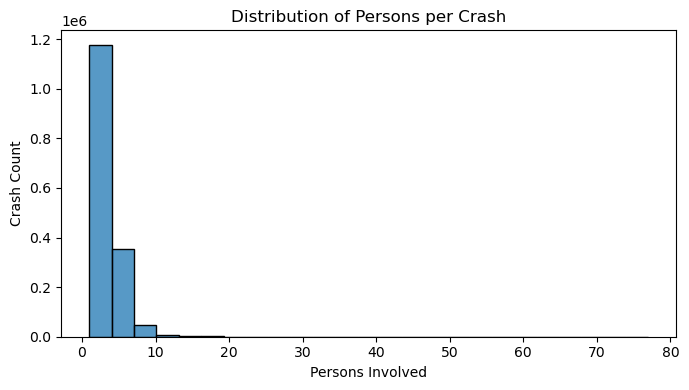

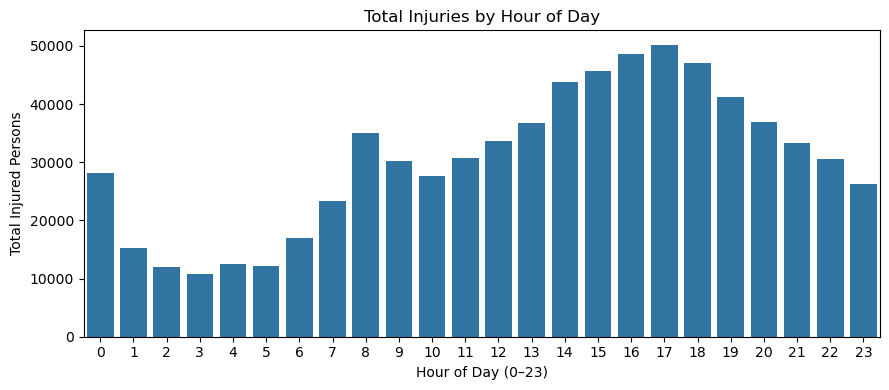

In [28]:
# ============================================
# F) Simple post-join visual checks
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# Crashes by Borough (After Integration)
# ============================================

if "BOROUGH" in df_merged.columns:
    plt.figure(figsize=(9,4))
    sns.countplot(
        data=df_merged.fillna({"BOROUGH": "UNKNOWN"}),
        x="BOROUGH",
        order=df_merged["BOROUGH"].fillna("UNKNOWN").value_counts().index
    )
    plt.title("Crashes by Borough (After Merge)")
    plt.xlabel("Borough")
    plt.ylabel("Number of Crashes")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


# ------------------------------
# Persons per Crash Distribution
# ------------------------------
plt.figure(figsize=(7,4))
sns.histplot(df_merged["persons_count"], bins=25)
plt.title("Distribution of Persons per Crash")
plt.xlabel("Persons Involved")
plt.ylabel("Crash Count")
plt.tight_layout()
plt.show()


# ------------------------------------------
# Total Injured Persons by Hour of the Day
# ------------------------------------------
hourly = (
    df_merged.groupby("CRASH_HOUR", as_index=False)["NUMBER OF PERSONS INJURED"]
    .sum()
    .sort_values("CRASH_HOUR")
)

plt.figure(figsize=(9,4))
sns.barplot(data=hourly, x="CRASH_HOUR", y="NUMBER OF PERSONS INJURED")
plt.title("Total Injuries by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Injured Persons")
plt.tight_layout()
plt.show()



In [ ]:
!pip install dash-mantine-components

In [30]:
from dash import Dash, dcc, html, Input, Output, State, callback
import plotly.express as px
import pandas as pd
import dash_mantine_components as dmc
from dash.exceptions import PreventUpdate
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'dash'

In [31]:
#df_dashData = pd.read_csv('S:\\Computer Science\\Semester 5\\Data Engineering and Visualization\\Project 1\\NYC-motor-vehicle-collisions\\data\\dashboard_ready.csv')
df_dashData = pd.read_csv("..\data\dashboard_ready.csv")


### **Search Functionality Explanation**

The dashboard includes a search bar that allows users to look up values across multiple categorical fields.
To prevent errors, the search feature only checks columns that actually exist in the `df_dash` dataset (e.g., BOROUGH, contributing factor, vehicle type).

Street-name columns are excluded because they are not part of the dashboard extract.



In [32]:
app = Dash(__name__) #creating the app
server = app.server

app.layout = dmc.MantineProvider(
    children = dmc.Container(
        fluid = True,
        children=[
    dmc.Title("NYC Motor Vehicle Collisions Dashboard", ta = "center", style = {"marginTop": 20, "marginBottom": 20}),

    #dmc.Select is basically a dropdown menus so user would be able to filter the data accordingly
    dmc.Select(
        label = "Select a Year", data = [{"label": str(y), "value": str(y)}
            for y in sorted(df_dashData['CRASH_YEAR'].unique())], id = "Year-select"),
                
    dmc.Select(
        label = "Select a Borough", data = [{"label": str(b), "value": str(b)}
            for b in sorted(df_dashData['BOROUGH'].dropna().unique())], id = "Borough-select"),
                        
    dmc.Select(
        label = "Select Vechile Type", data = [{"label": str(s), "value": str(s)}
            for s in sorted(df_dashData['VEHICLE TYPE CODE 1'].dropna().unique())], id = "Vehicle-type-select"),

    dmc.Select(
        label = "Select Contributing Factor", data = [{"label": str(f), "value": str(f)}
            for f in sorted(df_dashData['CONTRIBUTING FACTOR VEHICLE 1'].dropna().unique())], id = "Contributing-factor-select"
    ),

    #dcc.input is basically a search bar where users can type in their queries
    html.H1("NYC Motor Vehicle Collisions Search", style = {"textAlign": "left"}),
    dcc.Input(id = "Search-input", type = "text", placeholder = "Search...", style = {"marginTop": 20, "marginBottom": 20}),
    html.Div(id = "Search-results"),

    dmc.Button("Generate Report", id = "Generate-report-button", color = "grape", style = {"marginTop": 20, "marginBottom": 20}),
    html.Div(id = "Visualization-results")])) #basically an area for the visualizations to be displayed

#the callaback function to update the visualizations based on given input otherwise it wuld remian static
#so when something changes it tells the app to run which certain function and update the output
@app.callback( 
    Output("Visualization-results", "children"),
    Input("Generate-report-button", "n_clicks"),
    Input("Search-input", "n_submit"), #for the search to be triggered when we press enter
    State("Year-select", "value"),
    State("Borough-select", "value"),
    State("Vehicle-type-select", "value"),
    State("Contributing-factor-select", "value"),
    State("Search-input", "value"),
)

#this is for the dropdown filters and search bar
def update_visualizations(n_clicks, n_submit, year, borough, vehicle_type, factor, search_text):
    if not n_clicks and not n_submit:
        raise PreventUpdate

    df = df_dashData.copy()

    if year and "CRASH_YEAR" in df.columns:
        df["CRASH_YEAR"] = df["CRASH_YEAR"].astype(str).str.strip()
        df = df[df["CRASH_YEAR"] == str(year)]

    if borough and "BOROUGH" in df.columns:
        df["BOROUGH"] = df["BOROUGH"].astype(str).str.upper().str.strip()
        borough = borough.upper().strip()
        df = df[df["BOROUGH"] == borough]

    if vehicle_type and "VEHICLE TYPE CODE 1" in df.columns:
        df["VEHICLE TYPE CODE 1"] = df["VEHICLE TYPE CODE 1"].astype(str).str.upper().str.strip()
        vehicle_type = vehicle_type.upper().strip()
        df = df[df["VEHICLE TYPE CODE 1"] == vehicle_type]

    if factor and "CONTRIBUTING FACTOR VEHICLE 1" in df.columns:
        df["CONTRIBUTING FACTOR VEHICLE 1"] = df["CONTRIBUTING FACTOR VEHICLE 1"].astype(str).str.upper().str.strip()
        factor = factor.upper().strip()
        df = df[df["CONTRIBUTING FACTOR VEHICLE 1"] == factor]

    if search_text and search_text.strip():
        search_text = search_text.lower().strip()
        # Searchable columns (only include columns present in df_dash)
        search_columns = [
            "BOROUGH",
            "VEHICLE TYPE CODE 1",
            "CONTRIBUTING FACTOR VEHICLE 1",
            "ZIP CODE"
        ]

        search_columns = [col for col in search_columns if col in df.columns]

        
        if search_columns:
            if not df.empty and search_columns:
                df = df[df[search_columns].fillna('').apply(
                    lambda x: x.str.lower().str.contains(search_text)
                ).any(axis=1)]



    #for the visualizations based on the filtered data
    if df.empty:
        return html.Div([
        html.H3("No data matches the selected filters T_T", style={"color": "red"})
    ])

    fig1 = px.histogram(df, x="CRASH_MONTH", title="Crashes by Month")
    fig_bar = px.bar(
        df.groupby("BOROUGH")["NUMBER OF PERSONS INJURED"].sum().reset_index(),
        x="BOROUGH",
        y="NUMBER OF PERSONS INJURED",
        title="Total Injuries by Borough"
    )

    heatmap_data = df.groupby(["BOROUGH", "CRASH_MONTH"])["NUMBER OF PERSONS INJURED"].sum().reset_index()
    heatmap_data = heatmap_data.pivot(index="BOROUGH", columns="CRASH_MONTH", values="NUMBER OF PERSONS INJURED").fillna(0)

    fig_heatmap = px.imshow(
        heatmap_data,
        labels=dict(x="Month", y="Borough", color="Number of Persons Injured"),
        x=heatmap_data.columns,
        y=heatmap_data.index,
        text_auto=True,
        aspect="auto",
        title="Heatmap: Injuries by Borough and Month"
    )
    
    df = df.dropna(subset=["LATITUDE","LONGITUDE"])
    if df.empty:
        return html.Div([
            html.H3("No mappable coordinates available for this filter.", style={"color":"red"})
        ])

    fig_geomap = px.scatter_mapbox(
        df,
        lat="LATITUDE",
        lon="LONGITUDE",
        color="NUMBER OF PERSONS INJURED",
        size="NUMBER OF PERSONS INJURED",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=15,
        zoom=10,
        mapbox_style="carto-positron",
        title="Crash Locations by Number of Injuries"
    )

    #return tne visualizatiosn that should be displayed on the dashboard
    return html.Div([
        dcc.Graph(figure=fig1),
        dcc.Graph(figure=fig_bar),
        dcc.Graph(figure=fig_heatmap),
        dcc.Graph(figure=fig_geomap)
    ])

#run the app
if __name__ == "__main__":
    app.run(debug=True)



Research Questions: (All research questions will be in the README.md file)
Gamila
1. Which borough has the more frequent accidents (crashes)?
2. Which year has the highest casualties? (highest no. of people who died due to crashes) 

Sarah
1. What age group is most vulnerable to severe crashes?
2. Does crash severity vary by time of day? (Peak severity hours)

Mostafa
1. Which crash hour has the highest rate of fatal collisions per crash?
2. Which contributing factor is linked to the highest fatality rate per crash?

Omar 
1. Is there a relationship between person’s age and injury?
2. Which person type experiences the highest injury rate?

In [ ]:
!pip install --upgrade nbformat


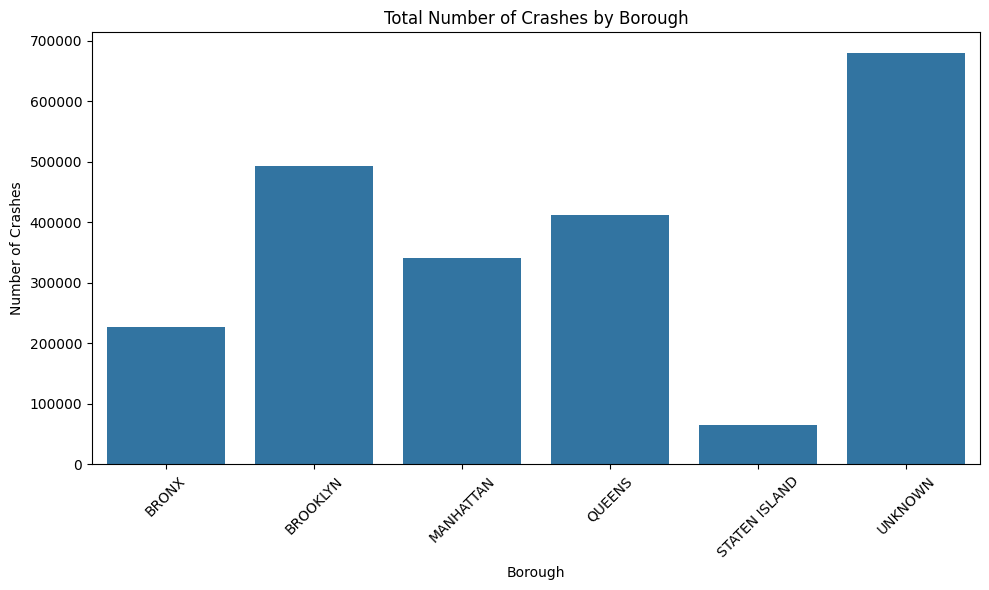

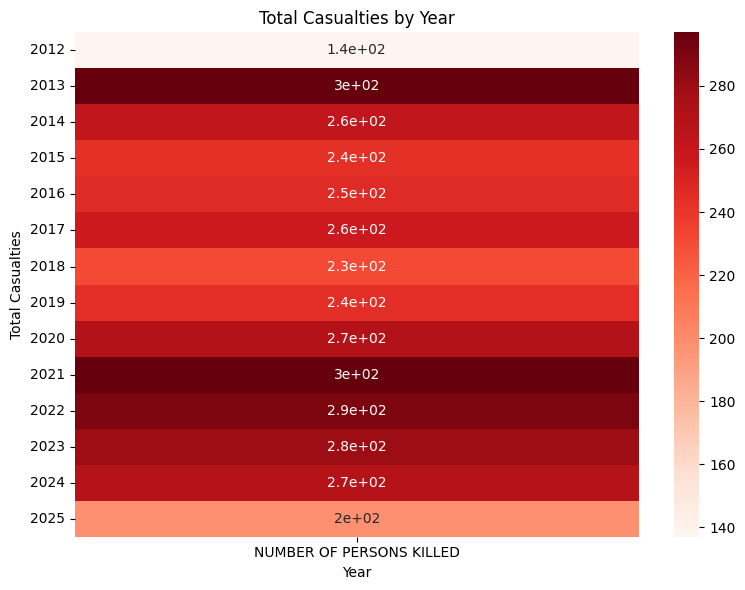

In [ ]:
#Charts for first two research questions
#df_integrated = pd.read_csv('S:\\Computer Science\\Semester 5\\Data Engineering and Visualization\\Project 1\\NYC-motor-vehicle-collisions\\notebooks\\integrated_collisions.csv')
df_integrated = pd.read_csv("..\data\integrated_collisions.csv")

# Which borough has the more frequent accidents?
borough_counts = df_integrated.groupby("BOROUGH").size().reset_index(name="NUM_CRASHES")

plt.figure(figsize=(10, 6))
sns.barplot(data=borough_counts, x="BOROUGH", y="NUM_CRASHES")

plt.title("Total Number of Crashes by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Which year has the highest casualties?
causalties = df_integrated.groupby("CRASH_YEAR")["NUMBER OF PERSONS KILLED"].sum().reset_index()
heatmap_data = causalties.pivot_table(
    index="CRASH_YEAR", 
    values="NUMBER OF PERSONS KILLED"
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Reds")

plt.title("Total Casualties by Year")
plt.xlabel("Year")
plt.ylabel("Total Casualties")
plt.tight_layout()
plt.show()



C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\3386640247.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



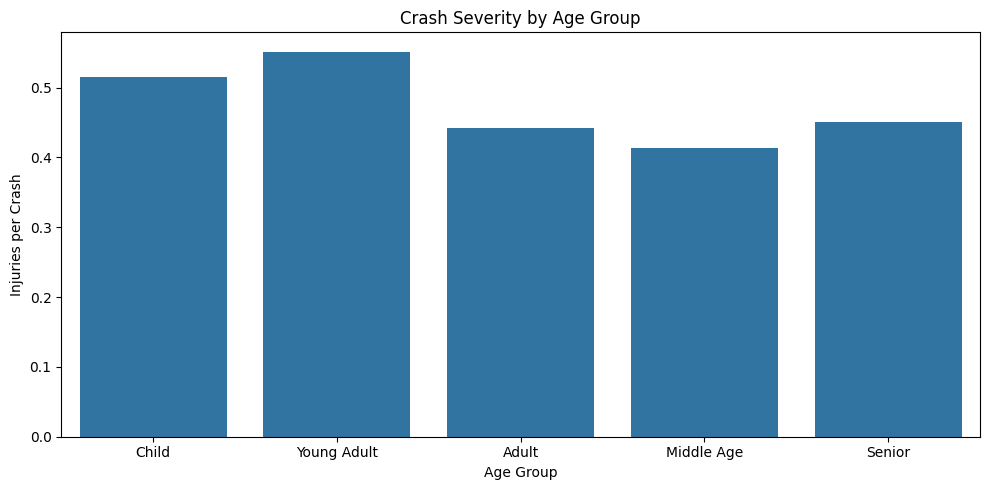

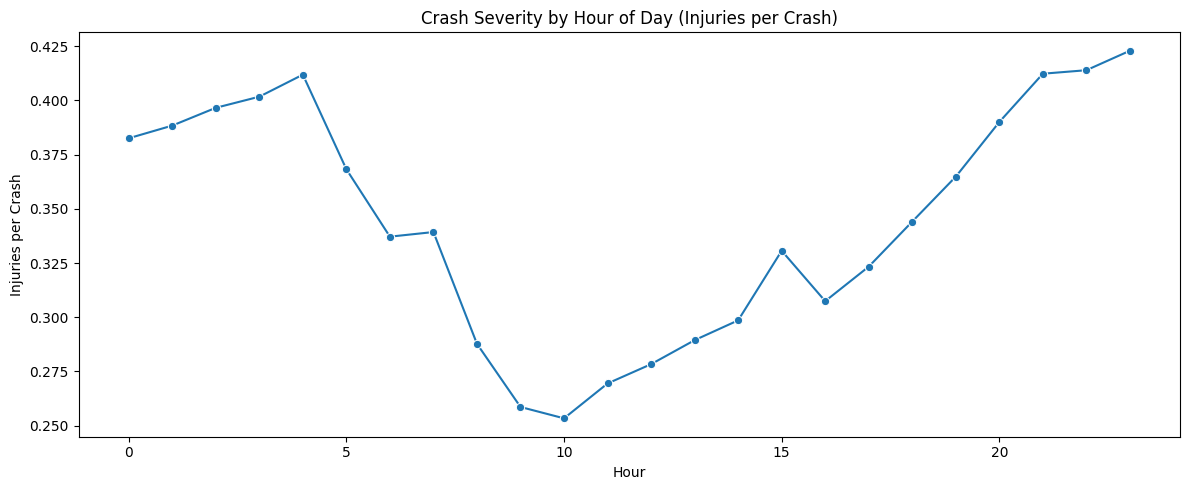

In [35]:
# RQ5: Age group vulnerability
df_age = df_integrated.dropna(subset=["median_age"]).copy()

bins = [0, 17, 29, 45, 60, 120]
labels = ["Child", "Young Adult", "Adult", "Middle Age", "Senior"]

df_age["AGE_GROUP"] = pd.cut(df_age["median_age"], bins=bins, labels=labels, right=True)

age_severity = (
    df_age.groupby("AGE_GROUP")
    .agg(
        crashes=("COLLISION_ID","count"),
        injuries=("NUMBER OF PERSONS INJURED","sum")
    )
)

age_severity["injuries_per_crash"] = (
    age_severity["injuries"] / age_severity["crashes"]
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=age_severity.reset_index(),
    x="AGE_GROUP",
    y="injuries_per_crash"
)
plt.title("Crash Severity by Age Group")
plt.ylabel("Injuries per Crash")
plt.xlabel("Age Group")
plt.tight_layout()
plt.show()

# RQ2: Severity by hour of day
severity_hour = (
    df_integrated.groupby("CRASH_HOUR")
    .agg(
        crashes=("COLLISION_ID","count"),
        injuries=("NUMBER OF PERSONS INJURED","sum")
    )
)

severity_hour["injuries_per_crash"] = severity_hour["injuries"] / severity_hour["crashes"]

plt.figure(figsize=(12,5))
sns.lineplot(
    data=severity_hour.reset_index(),
    x="CRASH_HOUR",
    y="injuries_per_crash",
    marker="o"
)
plt.title("Crash Severity by Hour of Day (Injuries per Crash)")
plt.xlabel("Hour")
plt.ylabel("Injuries per Crash")
plt.tight_layout()
plt.show()


Mostafa's Research Questions

# Q1: Which crash hour has the highest rate of fatal collisions per crash?

In [ ]:
df_integrated["CRASH_HOUR"] = pd.to_numeric(df_integrated["CRASH_HOUR"], errors="coerce")
df_integrated["is_fatal"] = (df_integrated["NUMBER OF PERSONS KILLED"] > 0).astype(int)

hour_summary = (
    df_integrated.groupby("CRASH_HOUR")
      .agg(
          total_crashes=("CRASH_HOUR", "count"),
          fatal_crashes=("is_fatal", "sum")
      )
)

hour_summary["fatal_rate"] = hour_summary["fatal_crashes"] / hour_summary["total_crashes"]
hour_summary = hour_summary.sort_index()

plt.figure(figsize=(12, 6))
plt.stem(hour_summary.index, hour_summary["fatal_rate"])
plt.xlabel("Crash Hour (0–23)")
plt.ylabel("Fatal Collisions per Crash")
plt.title("Fatal-Collision Rate by Crash Hour")
plt.xticks(hour_summary.index)
plt.tight_layout()
plt.show()

# Q2 Which contributing factor is linked to the highest fatality rate per crash?


In [ ]:
df_integrated["factor"] = df_integrated["CONTRIBUTING FACTOR VEHICLE 1"].fillna("Unknown")
df_integrated["is_fatal"] = (df_integrated["NUMBER OF PERSONS KILLED"] > 0).astype(int)
factor_summary = (
    df_integrated.groupby("factor")
      .agg(
          total_crashes=("factor", "count"),
          fatal_crashes=("is_fatal", "sum")
      )
)

factor_summary = factor_summary[factor_summary.index != "Unspecified"]
factor_summary["fatality_rate"] = factor_summary["fatal_crashes"] / factor_summary["total_crashes"]
factor_summary = factor_summary.sort_values("fatality_rate", ascending=False)

plt.figure(figsize=(14, 7))
plt.bar(factor_summary.index[:20], factor_summary["fatality_rate"].iloc[:20])
plt.xlabel("Contributing Factor")
plt.ylabel("Fatality Rate per Crash")
plt.title("Top Contributing Factors by Fatality Rate")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()


Omar's research questions

RQ3: Is there a relationship between person’s age and injury?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# --- Age bins ---
bins = [0, 17, 25, 35, 50, 65, 120]
labels = ['<18', '18-24', '25-34', '35-49', '50-64', '65+']

df_integrated['age_group'] = pd.cut(df_integrated['PERSON_AGE'], bins=bins, labels=labels)

# --- Group by age + injury ---
inj_by_age = df_integrated.groupby(['age_group', 'PERSON_INJURY']).size().unstack(fill_value=0)

display(inj_by_age)

# --- Plot ---
inj_by_age.plot(kind='bar', figsize=(10,5))
plt.title("Injury distribution by age group")
plt.xlabel("Age group")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


RQ4: Which person type experiences the highest injury rate?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure PERSON_TYPE & PERSON_INJURY have no weird missing values
df_integrated['PERSON_TYPE'] = df_integrated['PERSON_TYPE'].fillna('Unknown')
df_integrated['PERSON_INJURY'] = df_integrated['PERSON_INJURY'].fillna('Unknown')

# Total count per person type
total_per_type = df_integrated['PERSON_TYPE'].value_counts()
# Injured count per person type
injured_per_type = df_integrated[df_integrated['PERSON_INJURY'] != 'None']['PERSON_TYPE'].value_counts()

# Injury rate (%) = injured / total
injury_rate = (injured_per_type / total_per_type * 100).sort_values(ascending=False)

display(injury_rate)

# Plot
injury_rate.plot(kind='bar', figsize=(7,4))
plt.title("Injury Rate by Person Type (%)")
plt.xlabel("Person Type")
plt.ylabel("Injury Rate (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
